In [1]:
import qiskit

#### GHZ (Greenberger Horne Zilinger) state is a specific type of quantum entanglement state that requires 3 or more qubits. it is represented as 1/sqrt(2) [|000> + |111>]

In [13]:
#generating a circuit with n number of qubits

from qiskit import QuantumCircuit

# we will create a function to create a circuit in GHZ state:

def n_qubit_circuit(n:int)-> QuantumCircuit:
    #n (which should be an integer) is the parameter for num of qubits
    # ->QuantumCircuit - return variable

    if isinstance(n, int) and n>=2:  # validating n is an integer and greater than 2 (GHZ state requires more than 2 qubits)
        qc=QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):  #applying cnot gate on the rest of the qubits till end
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    return qc


n = 10
qc = n_qubit_circuit(n)
qc.draw()

    

┌───┐                                             
q_0: ┤ H ├──■──────────────────────────────────────────
     └───┘┌─┴─┐                                        
q_1: ─────┤ X ├──■─────────────────────────────────────
          └───┘┌─┴─┐                                   
q_2: ──────────┤ X ├──■────────────────────────────────
               └───┘┌─┴─┐                              
q_3: ───────────────┤ X ├──■───────────────────────────
                    └───┘┌─┴─┐                         
q_4: ────────────────────┤ X ├──■──────────────────────
                         └───┘┌─┴─┐                    
q_5: ─────────────────────────┤ X ├──■─────────────────
                              └───┘┌─┴─┐               
q_6: ──────────────────────────────┤ X ├──■────────────
                                   └───┘┌─┴─┐          
q_7: ───────────────────────────────────┤ X ├──■───────
                                        └───┘┌─┴─┐     
q_8: ────────────────────────────────────────┤ X ├──■──
                                             └───┘┌─┴─┐
q_9: ─────────────────────────────────────────────┤ X ├
                                                  └───┘

In [14]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z'+'I'*i + 'Z' + 'I'*(n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators =[SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


In [21]:

from qiskit_ibm_runtime import QiskitRuntimeService
service=QiskitRuntimeService(channel="ibm_quantum", 
                             token="828152830a71e2a562b8f59596e4755753350f186c24c2d6005fa6192bd895b04bbfc0ba4ac15046f0f64fc077fc8a774602de307e75da8bf9c9fa8b29fc37aa")


In [35]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=10)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Ensure qc is a single QuantumCircuit
if isinstance(qc, QuantumCircuit):
    isa_circuit = pm.run(qc)
elif isinstance(qc, list) and all(isinstance(c, QuantumCircuit) for c in qc):
    isa_circuit = pm.run(qc)[0]  # Take the first circuit
else:
    raise ValueError("qc should be a QuantumCircuit or a list of QuantumCircuit objects.")

# Apply layout to operators
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]


In [36]:
print(type(isa_circuit))

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


In [26]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

estimator = Estimator(backend, options = options)


In [38]:
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

cv5deja12hg0008wh540


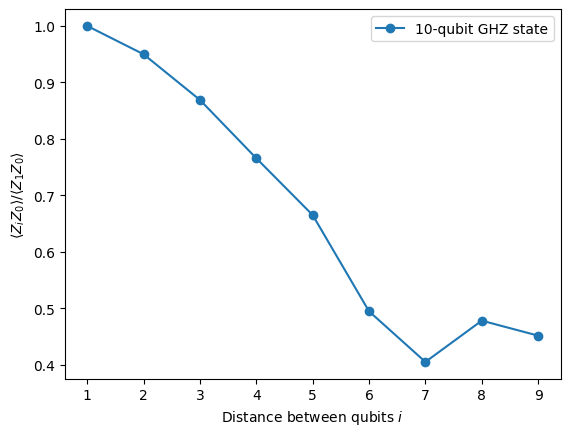

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService
 
# data
data = list(range(1, len(operators)+1)) # Distance between the Z operators
result = job.result()[0]
values = result.data.evs # Expectation value at each Z operator.
values = [v / values[0] for v in values] # Normalize the expectation values to evaluate how they decay with distance.
 
# plotting graph
plt.plot(data, values, marker='o', label='10-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $')
plt.legend()
plt.show()